In [1]:
import tensorflow as tf

IMAGE_SIZE = (256, 256)
NUM_CLASSES = 3

import tensorflow as tf
import random
import numpy as np
import os

SEED = 1998
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)


2022-11-18 11:42:15.287404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 11:42:15.472191: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 11:42:16.229135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-18 11:42:16.229245: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### 모델
UNET가 유사한 모델로 구성함   
1/10000로 스케일링함   
각 커널마다 초기화를 he_normal로 함   

In [2]:
import tensorflow as tf

# https://github.com/zhixuhao/unet/blob/master/model.py
def unet(input_size=(256, 256, 1), num_classes=3):
    inputs = tf.keras.Input(input_size)
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/10000)(inputs)
    conv1 = tf.keras.layers.Conv2D(
        8, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(x)
    conv1 = tf.keras.layers.Conv2D(
        8, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(
        16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool1)
    conv2 = tf.keras.layers.Conv2D(
        16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(
        32, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool2)
    conv3 = tf.keras.layers.Conv2D(
        32, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool3)
    conv4 = tf.keras.layers.Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool4)
    conv5 = tf.keras.layers.Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(
        64, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(tf.keras.layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge6)
    conv6 = tf.keras.layers.Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv6)

    up7 = tf.keras.layers.Conv2D(
        32, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(tf.keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(
        32, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge7)
    conv7 = tf.keras.layers.Conv2D(
        32, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv7)

    up8 = tf.keras.layers.Conv2D(
        16, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(tf.keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(
        16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge8)
    conv8 = tf.keras.layers.Conv2D(
        16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv8)

    up9 = tf.keras.layers.Conv2D(
        8, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(tf.keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(
        8, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge9)
    conv9 = tf.keras.layers.Conv2D(
        8, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv9)
    conv9 = tf.keras.layers.Conv2D(
        num_classes,
        3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal",
    )(conv9)
    conv10 = tf.keras.layers.Conv2D(num_classes, 1, activation="softmax")(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


model = unet()
model.summary()


2022-11-18 11:42:17.174157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-18 11:42:17.183361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-18 11:42:17.183833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-18 11:42:17.184627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['rescaling[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']             

In [3]:
import os
TRAIN_DATA_DIR = os.path.join(os.curdir, "dataset", "train", "data")
TRAIN_LABEL_DIR = os.path.join(os.curdir, "dataset", "train", "label")
def get_filenames():
    return [filename for filename in sorted(os.listdir(TRAIN_DATA_DIR))]
get_filenames()

['HFH_001_000.npy',
 'HFH_001_001.npy',
 'HFH_001_002.npy',
 'HFH_001_003.npy',
 'HFH_001_004.npy',
 'HFH_001_005.npy',
 'HFH_001_006.npy',
 'HFH_001_007.npy',
 'HFH_001_008.npy',
 'HFH_001_009.npy',
 'HFH_001_010.npy',
 'HFH_001_011.npy',
 'HFH_001_012.npy',
 'HFH_001_013.npy',
 'HFH_001_014.npy',
 'HFH_001_015.npy',
 'HFH_001_016.npy',
 'HFH_001_017.npy',
 'HFH_001_018.npy',
 'HFH_001_019.npy',
 'HFH_001_020.npy',
 'HFH_001_021.npy',
 'HFH_001_022.npy',
 'HFH_001_023.npy',
 'HFH_001_024.npy',
 'HFH_001_025.npy',
 'HFH_001_026.npy',
 'HFH_001_027.npy',
 'HFH_001_028.npy',
 'HFH_001_029.npy',
 'HFH_001_030.npy',
 'HFH_001_031.npy',
 'HFH_001_032.npy',
 'HFH_001_033.npy',
 'HFH_001_034.npy',
 'HFH_001_035.npy',
 'HFH_001_036.npy',
 'HFH_001_037.npy',
 'HFH_001_038.npy',
 'HFH_001_039.npy',
 'HFH_001_040.npy',
 'HFH_001_041.npy',
 'HFH_001_042.npy',
 'HFH_001_043.npy',
 'HFH_001_044.npy',
 'HFH_001_045.npy',
 'HFH_001_046.npy',
 'HFH_001_047.npy',
 'HFH_001_048.npy',
 'HFH_001_049.npy',


In [4]:
def get_filenames_5fold(filenames):
    filenames_5fold = []
    for _ in range(5):
        filenames_5fold.append([])
    for filename in filenames:
        index = (int(filename.split("_")[1]) - 1) // 5
        filenames_5fold[index].append(filename)
    return filenames_5fold

for item in get_filenames_5fold(get_filenames()):
    print(len(item))

620
620
608
594
608


In [5]:
import numpy as np
import pandas as pd

def yield_train_data_in(filenames_5fold, index):
    for filename in filenames_5fold[index]:
        with open(os.path.join(TRAIN_DATA_DIR, filename), "rb") as f:
            data = np.load(f).astype(np.float32)[..., np.newaxis]
            
        with open(os.path.join(TRAIN_LABEL_DIR, filename), "rb") as f:
            label = np.load(f).astype(int)
        yield data, label


for data, label in yield_train_data_in(
    get_filenames_5fold(get_filenames()), 1
):
    print(data.shape, data.dtype)
    print(pd.Series(data.flatten()).value_counts())
    print(label.shape, data.dtype)
    print(pd.Series(label.flatten()).value_counts())
    break


(256, 256, 1) float32
1.0     15334
2.0     14017
3.0     10434
0.0     10041
4.0      6672
5.0      4229
6.0      2310
7.0      1315
8.0       682
9.0       291
10.0      125
11.0       53
12.0       23
13.0        6
14.0        2
16.0        1
15.0        1
dtype: int64
(256, 256, 3) float32
0    131072
1     65536
dtype: int64


In [6]:
import numpy as np
import pandas as pd


def yield_train_data_except(filenames_5fold, index):
    for filenames in filenames_5fold[:index] + filenames_5fold[index + 1:]:
        for filename in filenames:
            with open(os.path.join(TRAIN_DATA_DIR, filename), "rb") as f:
                data = np.load(f).astype(np.float32)[..., np.newaxis]
                
            with open(os.path.join(TRAIN_LABEL_DIR, filename), "rb") as f:
                label = np.load(f).astype(int)
            yield data, label


for data, label in yield_train_data_except(
    get_filenames_5fold(get_filenames()), 1
):
    print(data.shape, data.dtype)
    print(pd.Series(data.flatten()).value_counts())
    print(label.shape, data.dtype)
    print(pd.Series(label.flatten()).value_counts())
    break


(256, 256, 1) float32
1.0     11678
2.0     11189
3.0      9553
4.0      7615
0.0      7399
5.0      5870
6.0      4276
7.0      3026
8.0      2074
9.0      1244
10.0      771
11.0      444
12.0      204
13.0      112
14.0       40
15.0       27
17.0        6
16.0        4
18.0        4
dtype: int64
(256, 256, 3) float32
0    131072
1     65536
dtype: int64


In [7]:
import tensorflow as tf
def get_dataset_in(filenames_5fold, index):
    output_signature = (
        tf.TensorSpec(shape=(*IMAGE_SIZE, 1)),
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3)),
    )
    return tf.data.Dataset.from_generator(
        lambda: yield_train_data_in(filenames_5fold, index),
        output_signature=output_signature,
    )

get_dataset_in(get_filenames_5fold(get_filenames()), 0)

<FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>

In [8]:
def get_dataset_except(filenames_5fold, index):
    output_signature = (
        tf.TensorSpec(shape=(*IMAGE_SIZE, 1)),
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3)),
    )
    return tf.data.Dataset.from_generator(
        lambda: yield_train_data_in(filenames_5fold, index),
        output_signature=output_signature,
    )

get_dataset_in(get_filenames_5fold(get_filenames()), 0)

<FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>

### Loss
주어진 데이터에는 배경(classs 0)이 많기 때문에 가중치를 적용한 cross entropy를 사용  
가중치를 각각 [0.1, 1000.0, 1000.0]로 줌
### Metrics
* 배경을 제외한 Mean IoU 
* 배경을 포함한 Mean IoU

In [9]:
from typing import Callable, Union
from tensorflow.keras import backend as K
# https://github.com/maxvfischer/keras-image-segmentation-loss-functions/blob/master/losses/multiclass_losses.py
def multiclass_weighted_cross_entropy(class_weights: list, is_logits: bool = False) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Multi-class weighted cross entropy.
        WCE(p, p̂) = −Σp*log(p̂)*class_weights
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Weight coefficients (list of floats)
    :param is_logits: If y_pred are logits (bool)
    :return: Weighted cross entropy loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the weighted cross entropy.
        :param y_true: Ground truth (tf.Tensor, shape=(None, None, None, None))
        :param y_pred: Predictions (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted cross entropy (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        assert len(class_weights) == y_pred.shape[-1], f"Number of class_weights ({len(class_weights)}) needs to be the same as number " \
                                                 f"of classes ({y_pred.shape[-1]})"

        if is_logits:
            y_pred = softmax(y_pred, axis=-1)

        y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())  # To avoid unwanted behaviour in K.log(y_pred)

        # p * log(p̂) * class_weights
        wce_loss = y_true * K.log(y_pred) * class_weights

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(wce_loss))
        wce_loss = K.mean(wce_loss, axis=axis_to_reduce)

        return -wce_loss

    return loss

In [10]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    multiclass_weighted_cross_entropy([1, 10000.0, 10000.0]),
    [
        tf.keras.metrics.OneHotMeanIoU(
            ignore_class=0, num_classes=3, name="MeanIOU_no_background"
        ),
        tf.keras.metrics.OneHotMeanIoU(num_classes=3, name="MeanIOU"),
    ],
)


### 데이터 세트
기존 이미지 중 20개를 훈련 세트로, 5개를 검증 세트로 설정함
기존 이미지를 채널마다 다른 이미지로 저장하여 데이터세트 늘림


In [11]:
train_dataset = get_dataset_except(get_filenames_5fold(get_filenames()), 2)
val_dataset = get_dataset_in(get_filenames_5fold(get_filenames()), 2)


### 훈련
Ealry Stopping을 적용함   
batch size를 8로 하고, 매 epoch마다 random shuffle함   

In [12]:
max_epochs = 100
history = model.fit(
    train_dataset.shuffle(2500).repeat(1).batch(8),
    epochs=max_epochs,
    validation_data=val_dataset.repeat(1).batch(8),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("model", save_best_only=True)
    ],
)


Epoch 1/100


2022-11-18 11:42:24.327351: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-18 11:42:25.023187: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


     75/Unknown - 10s 45ms/step - loss: 1.9830 - MeanIOU_no_background: 0.2506 - MeanIOU: 0.0174

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 18s 156ms/step - loss: 1.9902 - MeanIOU_no_background: 0.2513 - MeanIOU: 0.0190 - val_loss: 1.8269 - val_MeanIOU_no_background: 0.2513 - val_MeanIOU: 0.1731
Epoch 2/100
75/76 [============================>.] - ETA: 0s - loss: 1.7545 - MeanIOU_no_background: 0.1681 - MeanIOU: 0.2265

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 12s 139ms/step - loss: 1.7480 - MeanIOU_no_background: 0.1682 - MeanIOU: 0.2273 - val_loss: 1.6189 - val_MeanIOU_no_background: 0.2513 - val_MeanIOU: 0.2921
Epoch 3/100
76/76 [==============================] - ETA: 0s - loss: 1.2791 - MeanIOU_no_background: 0.1671 - MeanIOU: 0.3081

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 13s 147ms/step - loss: 1.2791 - MeanIOU_no_background: 0.1671 - MeanIOU: 0.3081 - val_loss: 1.1440 - val_MeanIOU_no_background: 0.2513 - val_MeanIOU: 0.3066
Epoch 4/100
75/76 [============================>.] - ETA: 0s - loss: 1.0271 - MeanIOU_no_background: 0.1711 - MeanIOU: 0.3174

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 12s 132ms/step - loss: 1.0345 - MeanIOU_no_background: 0.1706 - MeanIOU: 0.3176 - val_loss: 1.0864 - val_MeanIOU_no_background: 0.2385 - val_MeanIOU: 0.3286
Epoch 5/100
75/76 [============================>.] - ETA: 0s - loss: 0.9391 - MeanIOU_no_background: 0.1730 - MeanIOU: 0.3204

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 13s 140ms/step - loss: 0.9621 - MeanIOU_no_background: 0.1717 - MeanIOU: 0.3204 - val_loss: 0.9759 - val_MeanIOU_no_background: 0.2542 - val_MeanIOU: 0.3167
Epoch 6/100
75/76 [============================>.] - ETA: 0s - loss: 0.9662 - MeanIOU_no_background: 0.1964 - MeanIOU: 0.3179

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 12s 141ms/step - loss: 0.9611 - MeanIOU_no_background: 0.1971 - MeanIOU: 0.3180 - val_loss: 0.9303 - val_MeanIOU_no_background: 0.3888 - val_MeanIOU: 0.3234
Epoch 7/100
76/76 [==============================] - ETA: 0s - loss: 0.9120 - MeanIOU_no_background: 0.2290 - MeanIOU: 0.3243

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 12s 140ms/step - loss: 0.9120 - MeanIOU_no_background: 0.2290 - MeanIOU: 0.3243 - val_loss: 0.9221 - val_MeanIOU_no_background: 0.3928 - val_MeanIOU: 0.3242
Epoch 8/100
76/76 [==============================] - ETA: 0s - loss: 0.8872 - MeanIOU_no_background: 0.2275 - MeanIOU: 0.3265

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 12s 138ms/step - loss: 0.8872 - MeanIOU_no_background: 0.2275 - MeanIOU: 0.3265 - val_loss: 0.9013 - val_MeanIOU_no_background: 0.2689 - val_MeanIOU: 0.3339
Epoch 9/100
75/76 [============================>.] - ETA: 0s - loss: 0.8543 - MeanIOU_no_background: 0.2096 - MeanIOU: 0.3264

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 12s 134ms/step - loss: 0.8617 - MeanIOU_no_background: 0.2178 - MeanIOU: 0.3268 - val_loss: 0.8889 - val_MeanIOU_no_background: 0.3314 - val_MeanIOU: 0.3326
Epoch 10/100
76/76 [==============================] - ETA: 0s - loss: 0.8365 - MeanIOU_no_background: 0.2316 - MeanIOU: 0.3295

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 12s 141ms/step - loss: 0.8365 - MeanIOU_no_background: 0.2316 - MeanIOU: 0.3295 - val_loss: 0.8409 - val_MeanIOU_no_background: 0.3924 - val_MeanIOU: 0.3280
Epoch 11/100
76/76 [==============================] - ETA: 0s - loss: 0.8234 - MeanIOU_no_background: 0.2174 - MeanIOU: 0.3273

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 12s 137ms/step - loss: 0.8234 - MeanIOU_no_background: 0.2174 - MeanIOU: 0.3273 - val_loss: 0.8362 - val_MeanIOU_no_background: 0.5838 - val_MeanIOU: 0.3370
Epoch 12/100
76/76 [==============================] - ETA: 0s - loss: 0.8006 - MeanIOU_no_background: 0.2459 - MeanIOU: 0.3279

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


76/76 [==============================] - 12s 135ms/step - loss: 0.8006 - MeanIOU_no_background: 0.2459 - MeanIOU: 0.3279 - val_loss: 0.8012 - val_MeanIOU_no_background: 0.4812 - val_MeanIOU: 0.3347
Epoch 13/100
76/76 [==============================] - 8s 83ms/step - loss: 0.8174 - MeanIOU_no_background: 0.2506 - MeanIOU: 0.3248 - val_loss: 0.8896 - val_MeanIOU_no_background: 0.9981 - val_MeanIOU: 0.3181
Epoch 14/100
76/76 [==============================] - 8s 83ms/step - loss: 0.8498 - MeanIOU_no_background: 0.3181 - MeanIOU: 0.3194 - val_loss: 0.8797 - val_MeanIOU_no_background: 0.9961 - val_MeanIOU: 0.3112
Epoch 15/100
76/76 [==============================] - 8s 85ms/step - loss: 1.4801 - MeanIOU_no_background: 0.2477 - MeanIOU: 0.2810 - val_loss: 1.5991 - val_MeanIOU_no_background: 0.3128 - val_MeanIOU: 0.2442
Epoch 16/100
76/76 [==============================] - 8s 85ms/step - loss: 1.4833 - MeanIOU_no_background: 0.1959 - MeanIOU: 0.2792 - val_loss: 1.3950 - val_MeanIOU_no_backgro

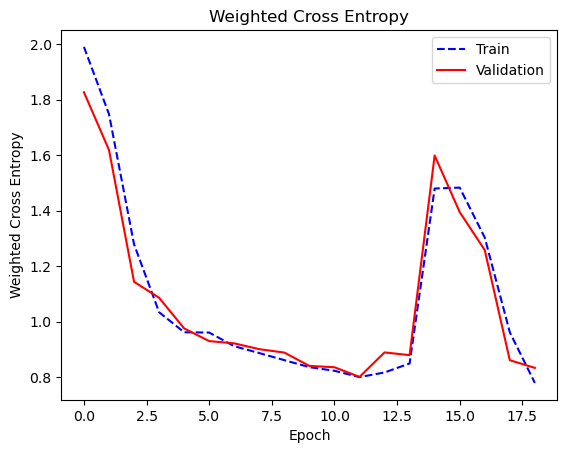

In [23]:
import matplotlib.pyplot as plt

real_epoch = len(history.history["loss"])
plt.plot(range(real_epoch), history.history["loss"], "b--", label="Train")
plt.plot(range(real_epoch), history.history["val_loss"], "r-", label="Validation")
plt.title("Weighted Cross Entropy")
plt.xlabel("Epoch")
plt.ylabel("Weighted Cross Entropy")
plt.legend()
plt.show()

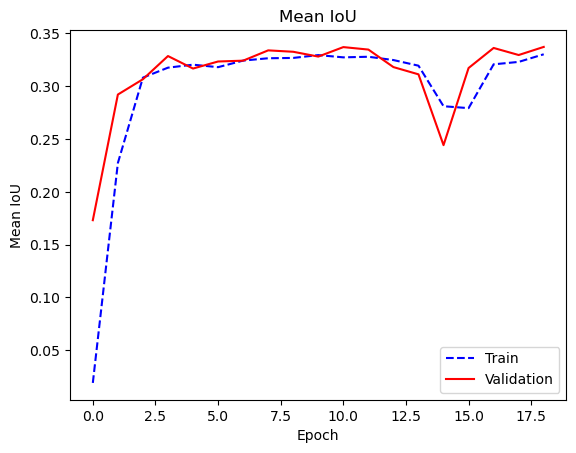

In [24]:
plt.plot(range(real_epoch), history.history["MeanIOU"], "b--", label="Train")
plt.plot(range(real_epoch), history.history["val_MeanIOU"], "r-", label="Validation")
plt.title("Mean IoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.show()

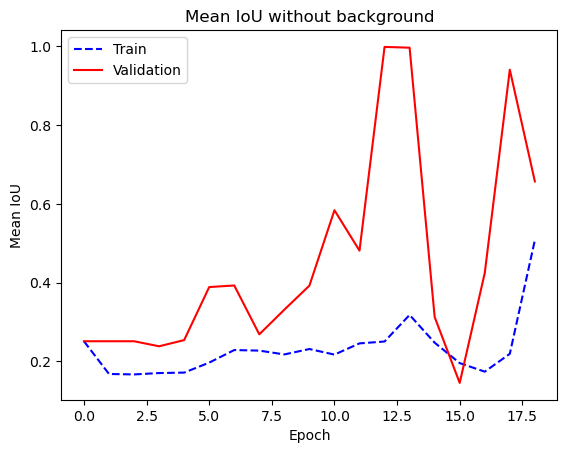

In [21]:
plt.plot(range(real_epoch), history.history["MeanIOU_no_background"], "b--", label="Train")
plt.plot(range(real_epoch), history.history["val_MeanIOU_no_background"], "r-", label="Validation")
plt.title("Mean IoU without background")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.show()

In [16]:
best_model = tf.keras.models.load_model("model", custom_objects={"loss": multiclass_weighted_cross_entropy([0.1, 1000.0, 1000.0])})

### 결과 및 한계
아래 사진을 보면 대략적인 위치는 분석하고 있으나 실제로 사용하기에는 너무 부족함   
적은 데이터 세트로 학습시킨 것이 원인으로 판단   
대량의 이미지 세트로 pretrian시킨 다음에 미세조정할 예정   

1/1 [==============================] - 1s 820ms/step
float32


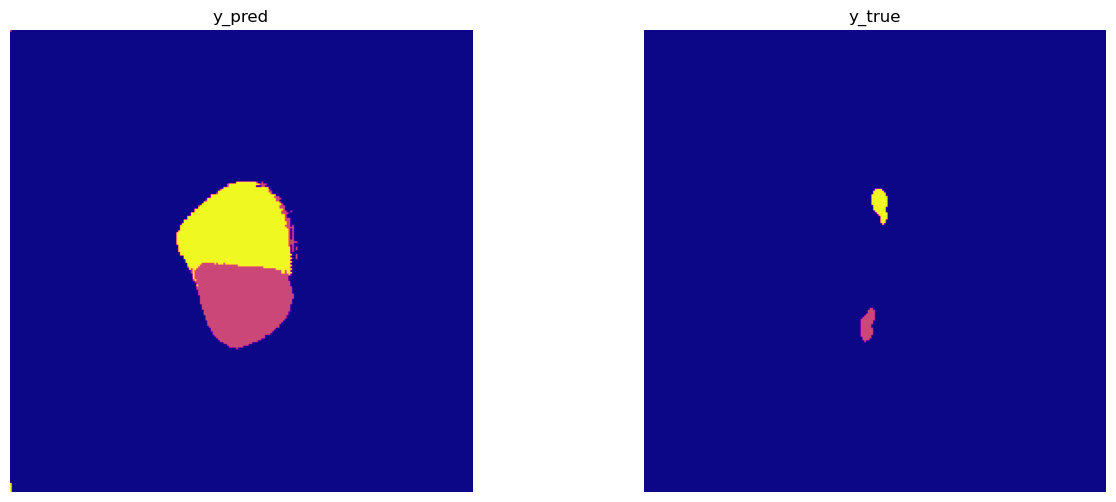

In [17]:
with open("dataset/train/data/HFH_001_057.npy", "rb") as f:
    arr = np.load(f).astype(np.float32)[np.newaxis, ...]
    preds = best_model.predict(arr)
    preds = preds.squeeze().argmax(axis=2)
    print(arr.dtype)
    plt.figure(figsize=(15, 6)) 
    plt.subplot(1, 2, 1)
    plt.imshow(preds, cmap="plasma")
    plt.title("y_pred")
    plt.axis("off")

with open("dataset/train/label/HFH_001_057.npy", "rb") as f:
    arr = np.load(f).astype(np.float32)
    target = arr.squeeze().argmax(axis=2)
    plt.subplot(1, 2, 2)
    plt.imshow(target, cmap="plasma")
    plt.title("y_true")
    plt.axis("off")
